In [1]:
import pandas as pd
import numpy as np
import re
import os
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
pd.set_option('display.max_colwidth',None)   #this displays the dataframe in full width
import collections
from collections import Counter

In [2]:
import torch
from torch.utils.data import TensorDataset,Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import time
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from transformers import BertTokenizer, BertModel
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM
# specify GPU
device = torch.device("cuda")
from wordcloud import WordCloud
import itertools
import seaborn as sns
import io


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
true_news = pd.read_csv('/content/drive/MyDrive/data/Sarcastic_dataset/Sarcasm_Hindi_Tweets-NON-SARCASTIC.csv')

print(true_news)

              username  \
0             Jatsland   
1       lifestyleship7   
2          Benish_shex   
3        Priyanshi_001   
4            ParthikaH   
...                ...   
10123       _jatin_ji_   
10124  MrParvezPathan2   
10125    KhajanchiAlok   
10126  PreciousBaatein   
10127       I_Shivee09   

                                                                                                                                                                 acctdesc  \
0                   → \nℳera☺ Attitude मेरी 😎शान है,\n\nAur ℳerä दिल 💓 हिंदुस्तान🇮🇳 है 💥.\n#NaMo_AgAiN\n\n*आप पृथ्वी के मेहमान हो,*\n*मालिक नहीं।*🌍🌸\n#चौधरी #JAAT #किसान   
1           Daily Lifestyle से संबंधित Educational, Business, Health and Fitness, Motivational Story, Sports, Digital World, बहुत सी जानकारी आपको हमारी वेबसाइट पर मिलेगी   
2      I may not be perfect but atlest I m not fake....\n\nMuslim ALHAMDULILAH 😇😍\npatriotic❤ \nproud to be a Pakistani 😍\nurdu speaking 😍\nMuhajir✌\nStraightforward...

In [5]:
fake_news =pd.read_csv('/content/drive/MyDrive/data/Sarcastic_dataset/Sarcasm_Hindi_Tweets-SARCASTIC.csv')
print(fake_news)

             username  \
0     Lokeshk67004736   
1        prayagraj_AU   
2          brand_dbm1   
3         Singh8Ankan   
4     PfCEAtft7vvZQRA   
...               ...   
6046        _Harsh_Jr   
6047        BUDHLADA_   
6048      Ad_lover_Dv   
6049      irealistech   
6050  NaveenK83101785   

                                                                                                                                        acctdesc  \
0                                                                                                                                            NaN   
1                                 सत्यमेव जयते\n\nभगवा ध्वज भारत का ऐतिहासिक एवं सांस्कृतिक ध्वज है । यह हिन्दुओं के महान प्रतीकों में से एक है।   
2                                                                          संस्थापक #भगवारक्षकटीम         राम राम दोस्तो🙏🙏🙏\n\nनोटिफिकेशन on करे   
3                                                                                         हिन्दू हूँ तो हिं

In [6]:
fake_news['label'] = 'sarcastic'
true_news['label'] = 'non-sarcastic'
df = pd.concat([fake_news, true_news], axis=0)
df = df.drop(['username','acctdesc','location','following','followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts', 'retweetcount', 'hashtags'] ,axis=1)
df = df.reset_index()
df = df.drop('index',axis=1)

In [7]:
def count_length():
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))

In [8]:
count_length()
df.tail(10)

,text,label,word_count
16169,"बॉलीवुड एक्टर #सुशांत_सिंह_राजपूत ने #फांसी लगाकर की खुदखुशी-\n#खुदखुशी करने वालो पर मुझे तरस नही आता,\nक्योंकि दुनिया मे #खुशी और #गम दोनों मिलते है जो उसे न झेल सके वो इंसान #बुझदिल होता है!\nसुशांत तुमने सही नहीं किया!\nखैर #अल्लाह घर वालों को सब्र अता करे-आमीन\n#SushantSinghRajput https://t.co/a8pRKR5GZU",non-sarcastic,45
16170,"बॉलीवुड एक्टर #सुशांत_सिंह_राजपूत ने #फांसी लगाकर की खुदखुशी-\n#खुदखुशी करने वालो पर मुझे तरस नही आता,\nक्योंकि दुनिया मे #खुशी और #गम दोनों मिलते है जो उसे न झेल सके वो इंसान #बुझदिल होता है!\nसुशांत तुमने सही नहीं किया!\nखैर #अल्लाह घर वालों को सब्र अता करे-आमीन\n#SushantSinghRajput https://t.co/a8pRKR5GZU",non-sarcastic,45
16171,तुम #बारिश और #चाय \n\nतीनों से मेरी #ज़िंदगी #मुकम्मल हो जाये \n\n#बजम \n\n#सुप्रभात \n#happy Good morning !!!!❣️ https://t.co/na3w1BBpCJ,non-sarcastic,19
16172,"बॉलीवुड एक्टर #सुशांत_सिंह_राजपूत ने #फांसी लगाकर की खुदखुशी-\n#खुदखुशी करने वालो पर मुझे तरस नही आता,\nक्योंकि दुनिया मे #खुशी और #गम दोनों मिलते है जो उसे न झेल सके वो इंसान #बुझदिल होता है!\nसुशांत तुमने सही नहीं किया!\nखैर #अल्लाह घर वालों को सब्र अता करे-आमीन\n#SushantSinghRajput https://t.co/a8pRKR5GZU",non-sarcastic,45
16173,हानि लाभ जीवन मरण यश अपयश ये आपके वश में नही होता सच है ।। फिल्मों में आत्महत्या न करने की प्रेरणा देने वाले सुशांत सिंह ने खुद आत्महत्या कर ली बेहद दुखद।। भगवान उनकी आत्मा को शांति दे 🙏🙏🙏#sad,non-sarcastic,40
16174,स्वर्गीय श्री सुशांत सिंह राजपूत ने हमें छिछोरे मूवी में काम करके यह सिखाया कि संघर्ष से दूर ना भागे । आत्महत्या ना करें और अब खुद ही आत्महत्या कर ली।\n#ripsushant #ripsushantsinghrajput #ripSSR #fuck2020 #sad https://t.co/WwhrA2iqQF,non-sarcastic,36
16175,"बॉलीवुड एक्टर #सुशांत_सिंह_राजपूत ने #फांसी लगाकर की खुदखुशी-\n#खुदखुशी करने वालो पर मुझे तरस नही आता,\nक्योंकि दुनिया मे #खुशी और #गम दोनों मिलते है जो उसे न झेल सके वो इंसान #बुझदिल होता है!\nसुशांत तुमने सही नहीं किया!\nखैर #अल्लाह घर वालों को सब्र अता करे-आमीन\n#SushantSinghRajput https://t.co/a8pRKR5GZU",non-sarcastic,45
16176,"#SushantSinghRajput #Suicide क्यों?? चमक धमक सिर्फ दिखावा है इस फिल्म इंडस्ट्री का, बाकी सब अंदर से टूटे हुए हैं चाहे फिर वो कितना भी महान अदाकार क्यों न सबकी जिंदगी सिर्फ दिखावा है सिर्फ घोर दिखावा 👎 #Sad",non-sarcastic,40
16177,हर हाल में #खुश रहना सीख लो🙃\n उस दिल को क्या #उदास रखना🧐\n जिसमें मेरा #भोले बसता हो❤🙏\n\n#जय_भोलेनाथ की 🙏☘🌺 📿🐚🛐\n\n@Being_Suchita @meShital_ \n@Oye_IShuu_ @sushma_pandey1\n@MansiSi62158538 @SSNaina_ https://t.co/5ouhhtgZjt,non-sarcastic,47
16178,"इतना कुछ पाने के बाद भी अगर इंसान जिदंगी से हार जाए , \n 🙄😒 तो उसने क्या पाया , और क्या वो खोए .... #sad #worstyear \n#sushantsinghrajpoot #sushant #ripsushant #RestInPeace 🙏🙏\n जिदंगी को हारना उत्तम नहीं है, जिदंगी को जीना सर्वोत्तम है...🙏🥺 https://t.co/D8P7sps7OI",non-sarcastic,48


In [9]:
import re
emoji_pattern = re.compile("["
        u"U0001F600-U0001F64F"  # emoticons
        u"U0001F300-U0001F5FF"  # symbols & pictographs
        u"U0001F680-U0001F6FF"  # transport & map symbols
        u"U0001F1E0-U0001F1FF"  # flags (iOS)
        u"U00002500-U00002BEF"  # chinese char
        u"U00002702-U000027B0"
        u"U00002702-U000027B0"
        u"U000024C2-U0001F251"
        u"U0001f926-U0001f937"
        u"U00010000-U0010ffff"
        u"u2640-u2642"
        u"u2600-u2B55"
        u"u200d"
        u"u23cf"
        u"u23e9"
        u"u231a"
        u"ufe0f"  # dingbats
        u"u3030"
                           "]+", flags=re.UNICODE)

In [10]:
for i in range(len(df)):
    df['text'][i] = emoji_pattern.sub(r'', df['text'][i])
count_length()

Streaming output truncated to the last 5000 lines.
<ipython-input-10-34ec530bab70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = emoji_pattern.sub(r'', df['text'][i])
<ipython-input-10-34ec530bab70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = emoji_pattern.sub(r'', df['text'][i])
<ipython-input-10-34ec530bab70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = emoji_pattern.sub(r''

In [11]:
import re
def processText(text):
    text = text.lower()
    text = re.sub('((www.[^s]+)|(https?://[^s]+))','',text)
    text = re.sub('@[^s]+','',text)
    text = re.sub('[s]+', ' ', text)
    text = re.sub(r'#([^s]+)', r'1', text)


    return text

In [12]:
for i in range(len(df)):
    df['text'][i] = processText(df['text'][i])

Streaming output truncated to the last 5000 lines.
<ipython-input-12-45b070bef18a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = processText(df['text'][i])
<ipython-input-12-45b070bef18a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = processText(df['text'][i])
<ipython-input-12-45b070bef18a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = processText(df['text'][i])
<ipython-input-1

In [13]:
!pip install indic-nlp-library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.9 MB/s eta 0:00:00
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.16.1
    Uninstalling Pygments-2.16.1:
      Successfully uninstalled Pygments-2.16.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.18.1
    Uninstalling docutils-0.18.1:
      Successfully uninstalled docutils-0.18.1
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2
ERROR: pip's dependency resolver does not currently 

In [14]:
from indicnlp.tokenize import indic_tokenize
def tokenization(indic_string):
    tokens = []
    for t in indic_tokenize.trivial_tokenize(indic_string):
        tokens.append(t)
    return tokens
df['text'] = df['text'].apply(lambda x: tokenization(x))

In [15]:
for i in range(len(df)):
    df['text'][i] = [s.replace("\n", "") for s in df['text'][i]]

Streaming output truncated to the last 5000 lines.
<ipython-input-15-cf3b4030ff34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = [s.replace("\n", "") for s in df['text'][i]]
<ipython-input-15-cf3b4030ff34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = [s.replace("\n", "") for s in df['text'][i]]
<ipython-input-15-cf3b4030ff34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = [s.repl

In [16]:
stopwords_hi = ['तुम','मेरी','मुझे','क्योंकि','हम','प्रति','अबकी','आगे','माननीय','शहर','बताएं','कौनसी','क्लिक','किसकी','बड़े','मैं','and','रही','आज','लें','आपके','मिलकर','सब','मेरे','जी','श्री','वैसा','आपका','अंदर', 'अत', 'अपना', 'अपनी', 'अपने', 'अभी', 'आदि', 'आप', 'इत्यादि', 'इन', 'इनका', 'इन्हीं', 'इन्हें', 'इन्हों', 'इस', 'इसका', 'इसकी', 'इसके', 'इसमें', 'इसी', 'इसे', 'उन', 'उनका', 'उनकी', 'उनके', 'उनको', 'उन्हीं', 'उन्हें', 'उन्हों', 'उस', 'उसके', 'उसी', 'उसे', 'एक', 'एवं', 'एस', 'ऐसे', 'और', 'कई', 'कर','करता', 'करते', 'करना', 'करने', 'करें', 'कहते', 'कहा', 'का', 'काफ़ी', 'कि', 'कितना', 'किन्हें', 'किन्हों', 'किया', 'किर', 'किस', 'किसी', 'किसे', 'की', 'कुछ', 'कुल', 'के', 'को', 'कोई', 'कौन', 'कौनसा', 'गया', 'घर', 'जब', 'जहाँ', 'जा', 'जितना', 'जिन', 'जिन्हें', 'जिन्हों', 'जिस', 'जिसे', 'जीधर', 'जैसा', 'जैसे', 'जो', 'तक', 'तब', 'तरह', 'तिन', 'तिन्हें', 'तिन्हों', 'तिस', 'तिसे', 'तो', 'था', 'थी', 'थे', 'दबारा', 'दिया', 'दुसरा', 'दूसरे', 'दो', 'द्वारा', 'न', 'नहीं', 'ना', 'निहायत', 'नीचे', 'ने', 'पर', 'पर', 'पहले', 'पूरा', 'पे', 'फिर', 'बनी', 'बही', 'बहुत', 'बाद', 'बाला', 'बिलकुल', 'भी', 'भीतर', 'मगर', 'मानो', 'मे', 'में', 'यदि', 'यह', 'यहाँ', 'यही', 'या', 'यिह', 'ये', 'रखें', 'रहा', 'रहे', 'ऱ्वासा', 'लिए', 'लिये', 'लेकिन', 'व', 'वर्ग', 'वह', 'वह', 'वहाँ', 'वहीं', 'वाले', 'वुह', 'वे', 'वग़ैरह', 'संग', 'सकता', 'सकते', 'सबसे', 'सभी', 'साथ', 'साबुत', 'साभ', 'सारा', 'से', 'सो', 'ही', 'हुआ', 'हुई', 'हुए', 'है', 'हैं', 'हो', 'होता', 'होती', 'होते', 'होना', 'होने', 'अपनि', 'जेसे', 'होति', 'सभि', 'तिंहों', 'इंहों', 'दवारा', 'इसि', 'किंहें', 'थि', 'उंहों', 'ओर', 'जिंहें', 'वहिं', 'अभि', 'बनि', 'हि', 'उंहिं', 'उंहें', 'हें', 'वगेरह', 'एसे', 'रवासा', 'कोन', 'निचे', 'काफि', 'उसि', 'पुरा', 'भितर', 'हे', 'बहि', 'वहां', 'कोइ', 'यहां', 'जिंहों', 'तिंहें', 'किसि', 'कइ', 'यहि', 'इंहिं', 'जिधर', 'इंहें', 'अदि', 'इतयादि', 'हुइ', 'कोनसा', 'इसकि', 'दुसरे', 'जहां', 'अप', 'किंहों', 'उनकि', 'भि', 'वरग', 'हुअ', 'जेसा', 'नहिं']
stopwords_en = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

to_be_removed = stopwords_hi + stopwords_en

In [17]:
for i in range(len(df)):
    df['text'][i]=[ele for ele in df['text'][i] if ele not in (to_be_removed)]
count_length()
df.tail(10)

Streaming output truncated to the last 5000 lines.
<ipython-input-17-209eca5ca5be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=[ele for ele in df['text'][i] if ele not in (to_be_removed)]
<ipython-input-17-209eca5ca5be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=[ele for ele in df['text'][i] if ele not in (to_be_removed)]
<ipython-input-17-209eca5ca5be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

,text,label,word_count
16169,"[बॉलीवुड, एक्टर, 1]",non-sarcastic,3
16170,"[बॉलीवुड, एक्टर, 1]",non-sarcastic,3
16171,[1],non-sarcastic,1
16172,"[बॉलीवुड, एक्टर, 1]",non-sarcastic,3
16173,"[हानि, लाभ, जीवन, मरण, यश, अपयश, वश, नही, सच, ।, ।, फिल्मों, आत्महत्या, प्रेरणा, देने, सुशांत, सिंह, खुद, आत्महत्या, ली, बेहद, दुखद, ।, ।, भगवान, आत्मा, शांति, दे, 🙏🙏🙏, #]",non-sarcastic,30
16174,"[स्वर्गीय, सुशांत, सिंह, राजपूत, हमें, छिछोरे, मूवी, काम, करके, सिखाया, संघर्ष, दूर, भागे, ।, आत्महत्या, अब, खुद, आत्महत्या, ली, ।, 1]",non-sarcastic,21
16175,"[बॉलीवुड, एक्टर, 1]",non-sarcastic,3
16176,[1],non-sarcastic,1
16177,"[हर, हाल, 1]",non-sarcastic,3
16178,"[इतना, पाने, अगर, इंसान, जिदंगी, हार, जाए, ,, , 🙄😒, उसने, क्या, पाया, ,, क्या, वो, खोए, ., ., ., ., 1]",non-sarcastic,22


array([<Axes: title={'center': 'non-sarcastic'}>,
       <Axes: title={'center': 'sarcastic'}>], dtype=object)

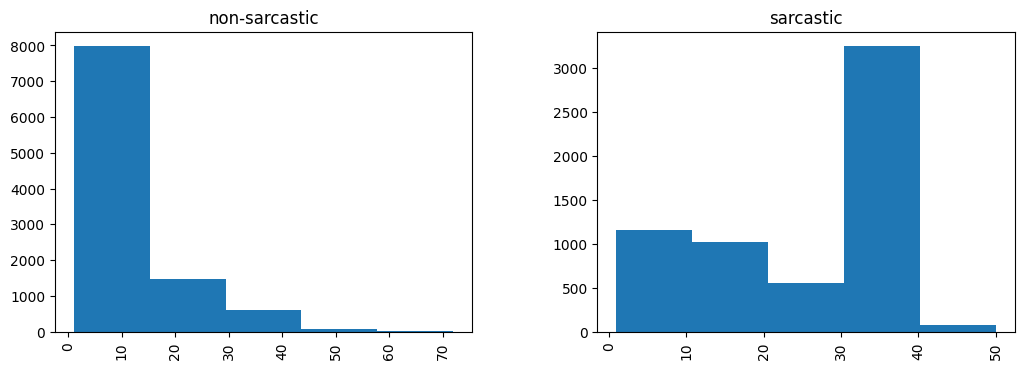

In [18]:
df.hist(column = 'word_count', by ='label',figsize=(12,4), bins = 5)

In [19]:
corpus_list =[]
for i in range(len(df)):
    corpus_list +=df['text'][i]
counter=collections.Counter(corpus_list)
print(counter)

Counter({'.': 26957, '1': 10889, ',': 10422, 'नेहरू': 6695, '!': 5524, '': 5205, 'लेते': 4775, '।': 4027, '-': 2851, 'शी': 2710, '(': 2610, ')': 2606, 'अगर': 2517, 'मास्टर': 2460, 'सिगरेट': 2410, 'बीवी': 2390, 'किताब': 2390, 'वश': 2385, 'जिनपिंग': 2380, 'पटाकर': 2380, 'पिलाकर': 2380, 'तिब्बत': 2380, 'सीधे': 2380, 'शंघाई': 2380, 'कब्जा': 2380, 'इश्क़': 2380, 'जंग': 2380, 'जायज़': 2380, 'द': 2380, 'ठरकी': 2380, 'कांग्रेस': 2310, 'एडविना': 2230, 'आक': 2230, 'थू': 2230, 'जय': 2200, '💦💦1': 2190, '"': 1940, 'वो': 1775, 'स्कूल': 1640, 'हमारे': 1455, 'w': 1268, 'चला': 975, '/': 955, 'बस': 935, 'मंत्री': 935, 'सरकार': 930, 'पता': 890, 'v': 873, 'बच्चों': 865, 'आने': 855, 'बेटे': 855, 'रहते': 845, 'बड़ा': 839, 'गांव': 825, 'मोहल्ले': 820, 'भतीजे': 820, 'कैंटीन': 820, 'भांजे': 820, 'पढ़ाने': 820, 'रिश्तेदार': 820, 'पिता': 815, 'चीन': 808, 'हरे': 735, 'देता': 655, '*': 630, 'क्या': 571, 'अब': 561, 'लोग': 560, 'z': 555, 'खत्म': 555, 'दिल्ली': 525, 'जिंदगी': 525, 'है1': 516, 'कोरोना': 476, 'कृष्ण': 

In [20]:
to_remove = ['नेहरू', 'लेते', 'कटाक्ष', 'जय', 'शी', 'अगर', 'मास्टर', 'वो', 'सिगरेट', 'बीवी', 'इश्क़', 'किताब', 'वश', 'पटाकर', 'पिलाकर']
for i in range(len(df)):
    df['text'][i]=[ele for ele in df['text'][i] if ele not in (to_remove)]
count_length()

Streaming output truncated to the last 5000 lines.
<ipython-input-20-6ac0d2268941>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=[ele for ele in df['text'][i] if ele not in (to_remove)]
<ipython-input-20-6ac0d2268941>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=[ele for ele in df['text'][i] if ele not in (to_remove)]
<ipython-input-20-6ac0d2268941>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[

In [21]:
least_common= [word for word, word_count in Counter(corpus_list).most_common()[:-50:-1]]
for i in range(len(df)):
    df['text'][i]=[ele for ele in df['text'][i] if ele not in (least_common)]

Streaming output truncated to the last 5000 lines.
<ipython-input-21-b753871445d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=[ele for ele in df['text'][i] if ele not in (least_common)]
<ipython-input-21-b753871445d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=[ele for ele in df['text'][i] if ele not in (least_common)]
<ipython-input-21-b753871445d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

array([<Axes: title={'center': 'non-sarcastic'}>,
       <Axes: title={'center': 'sarcastic'}>], dtype=object)

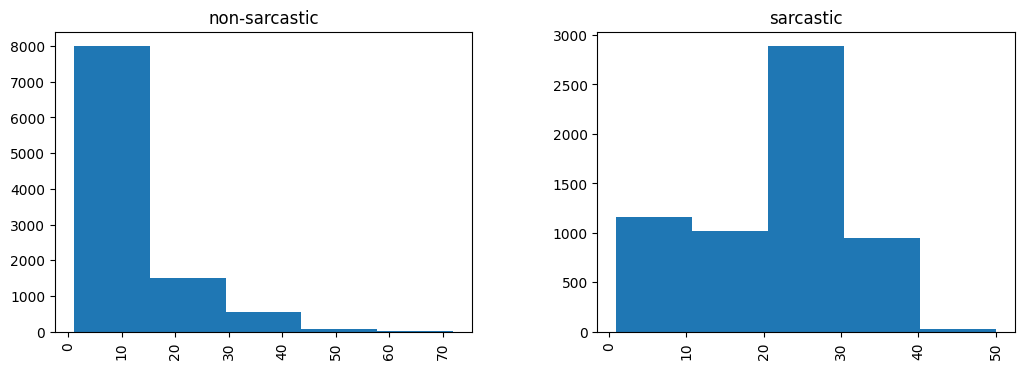

In [22]:
df.hist(column = 'word_count', by ='label',figsize=(12,4), bins = 5)

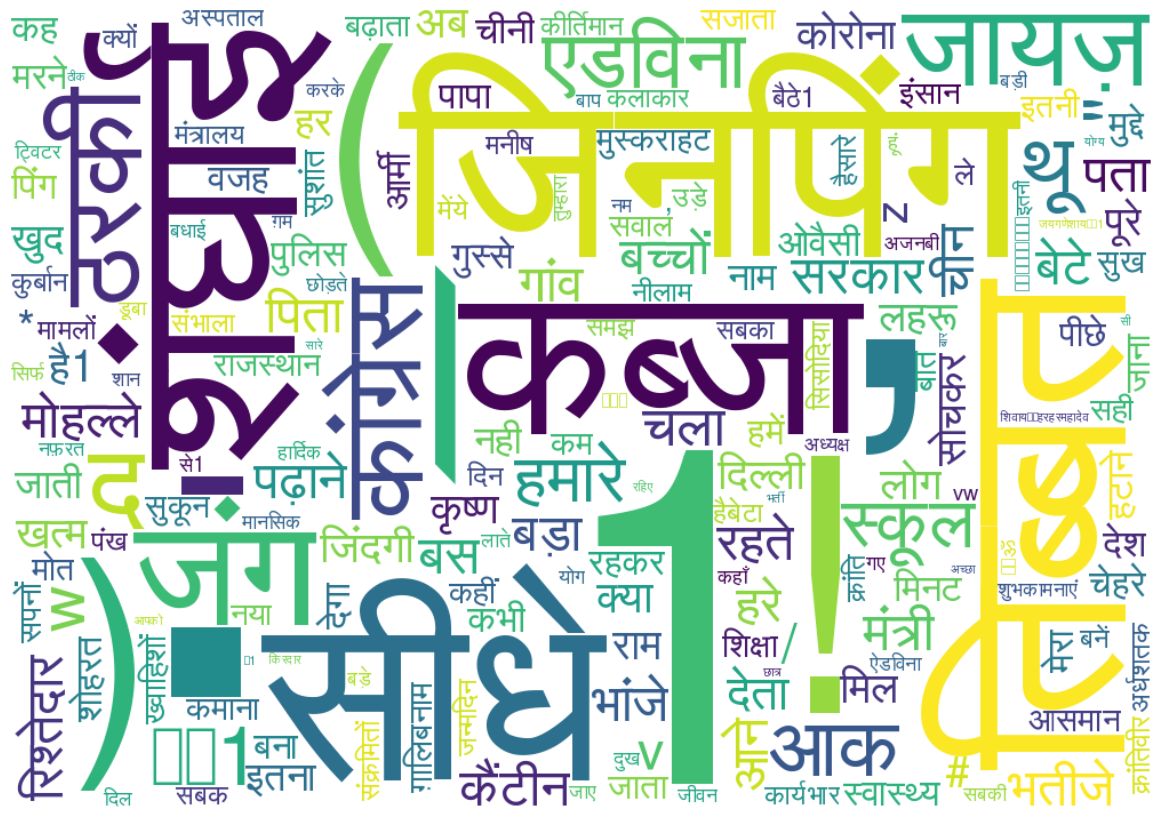

In [23]:
import matplotlib.pyplot as plt
df_list = []
for i in range(len(df)):
    df_list +=df['text'][i]
font = "/content/drive/MyDrive/data/Sarcastic_dataset/Gargi.ttf"
dictionary=Counter(df_list)
from wordcloud import WordCloud

# Remove newline characters from words in the dictionary
cleaned_dictionary = {word.replace('\n', ' '): count for word, count in dictionary.items()}

wordcloud = WordCloud(width = 1000, height = 700,
                background_color ='white',
                min_font_size = 10, font_path= font).generate_from_frequencies(cleaned_dictionary)
# plot the WordCloud image
plt.figure(figsize = (18, 8), facecolor = None)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [24]:
# Tokenize the text data
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [25]:
# Prepare the DataLoader
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
MAX_LEN = 128

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [26]:
# Convert text and labels to lists for DataLoader
texts = df['text'].apply(lambda x: ' '.join(x)).tolist()
labels = df['label'].apply(lambda x: 1 if x == 'sarcastic' else 0).tolist()


In [27]:
# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [28]:
# Define the Model and Training Parameters
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
# Train the Model
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")

Epoch 1/5, Loss: 0.18232652079659353
Epoch 2/5, Loss: 0.10303434696666118
Epoch 3/5, Loss: 0.08542535978623254
Epoch 4/5, Loss: 0.06794411905156074
Epoch 5/5, Loss: 0.07416652411872024


In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Evaluate the Model
model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.9762051915945612
Precision: 0.9905254091300603
Recall: 0.9457236842105263
F1 Score: 0.9676062263357174


In [36]:
# Function to predict sarcasm
def predict_sarcasm(text):
    # Tokenize text
    inputs = tokenizer(text, return_tensors="pt").to(device)  # Move inputs to GPU

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted label
    logits = outputs.logits
    # Move logits to CPU before applying np.argmax
    predicted_id = np.argmax(logits.cpu())

    # Map predicted ID to label
    if predicted_id == 1:
        return "Sarcastic"
    else:
        return "Non-Sarcastic"

In [ ]:
# To test the model used the some latest sarcastic and non-sarcastic dataset

In [38]:
# Example usage:
example_text = "जयपुर के बनीपार्क स्थित महात्मा गांधी सरकारी स्कूल में 3 अगस्त को लेवल-2 टीचर बबीता चौधरी क्लास ले रही थीं. तभी टीचर को गुस्सा आ गया और उन्होंने 10 साल की बच्ची के बाल पकड़कर उसे जमीन पर पटक दिया. इसके बाद बच्ची जोर-जोर से चिल्लाई और फिर चुपचाप अपनी जगह पर जाकर बैठ गई. इस घटना की वीडियो भी सामने आया ह"
prediction = predict_sarcasm(example_text)
print(f"Prediction for '{example_text}': {prediction}")

Prediction for 'जयपुर के बनीपार्क स्थित महात्मा गांधी सरकारी स्कूल में 3 अगस्त को लेवल-2 टीचर बबीता चौधरी क्लास ले रही थीं. तभी टीचर को गुस्सा आ गया और उन्होंने 10 साल की बच्ची के बाल पकड़कर उसे जमीन पर पटक दिया. इसके बाद बच्ची जोर-जोर से चिल्लाई और फिर चुपचाप अपनी जगह पर जाकर बैठ गई. इस घटना की वीडियो भी सामने आया ह': Sarcastic


In [39]:
# Example usage:
example_text = "बांग्लादेश की प्रधानमंत्री शेख हसीना ने इस्तीफा दे दिया है. उन्होंने देश भी छोड़ दिया है. शेख हसीना के इस्तीफे की मांग को लेकर कई दिनों से प्रदर्शन चल रहा था."
prediction = predict_sarcasm(example_text)
print(f"Prediction for '{example_text}': {prediction}")

Prediction for 'बांग्लादेश की प्रधानमंत्री शेख हसीना ने इस्तीफा दे दिया है. उन्होंने देश भी छोड़ दिया है. शेख हसीना के इस्तीफे की मांग को लेकर कई दिनों से प्रदर्शन चल रहा था.': Sarcastic


In [40]:
# Example usage:
example_text = "उत्तराखंड के अल्मोड़ा में जन्मे लक्ष्य सेन को बैडमिंटन विरासत में मिला है. उनके दादा सीएल सेन को अल्मोड़ा में बैडमिंटन का भीष्म पितामह कहा जाता है. लक्ष्य के पिता डीके सेन नेशनल लेवल पर बैडमिंटन खेल चुके हैं और राष्ट्रीय स्तर के कोच भी हैं. डीके सेन वर्तमान में प्रकाश पादुकोण अकादमी में अपनी दे रहे हैं. लक्ष्य सेन के भाई चिराग सेन भी इंटरनेशनल लेवल पर बैडमिंटन में भारत का प्रतिनिधित्व कर चुके हैं."
prediction = predict_sarcasm(example_text)
print(f"Prediction for '{example_text}': {prediction}")

Prediction for 'उत्तराखंड के अल्मोड़ा में जन्मे लक्ष्य सेन को बैडमिंटन विरासत में मिला है. उनके दादा सीएल सेन को अल्मोड़ा में बैडमिंटन का भीष्म पितामह कहा जाता है. लक्ष्य के पिता डीके सेन नेशनल लेवल पर बैडमिंटन खेल चुके हैं और राष्ट्रीय स्तर के कोच भी हैं. डीके सेन वर्तमान में प्रकाश पादुकोण अकादमी में अपनी दे रहे हैं. लक्ष्य सेन के भाई चिराग सेन भी इंटरनेशनल लेवल पर बैडमिंटन में भारत का प्रतिनिधित्व कर चुके हैं.': Non-Sarcastic


In [41]:
# Example usage:
example_text = "डायरेक्टर शॉन लेवी की बनाई फिल्म 'डेडपूल एंड वुल्वरीन' के पहले रिव्यू सामने आ गए हैं. फिल्म में एक्टर रायन रेनॉल्ड्स ने अपने डेडपूल के किरदार में हैं. तो वहीं एक्टर ह्यू जैकमैन अपने एक्स-मैन के हीरो वुल्वरीन के रोल में एक बार फिर नजर आए हैं."
prediction = predict_sarcasm(example_text)
print(f"Prediction for '{example_text}': {prediction}")

Prediction for 'डायरेक्टर शॉन लेवी की बनाई फिल्म 'डेडपूल एंड वुल्वरीन' के पहले रिव्यू सामने आ गए हैं. फिल्म में एक्टर रायन रेनॉल्ड्स ने अपने डेडपूल के किरदार में हैं. तो वहीं एक्टर ह्यू जैकमैन अपने एक्स-मैन के हीरो वुल्वरीन के रोल में एक बार फिर नजर आए हैं.': Non-Sarcastic


In [42]:
# Example usage:
example_text = "  पेरिस ओलंपिक 2024 में अब तक भारत ने 3 ब्रॉन्ज मेडल जीते हैं. यह सभी मेडल शूटिंग में आए हैं. मगर 9वें दिन (4 जुलाई) यानी रविवार को भारत को कोई मेडल नही मिला. यह दिन भारत के लिए मिला-जुला ही रहा है. हरमनप्रीत सिंह की कप्तानी में भारतीय हॉकी टीम ने शानदार जीत दर्ज करते हुए सेमीफाइनल में एंट्री कर ली है."
prediction = predict_sarcasm(example_text)
print(f"Prediction for '{example_text}': {prediction}")

Prediction for '  पेरिस ओलंपिक 2024 में अब तक भारत ने 3 ब्रॉन्ज मेडल जीते हैं. यह सभी मेडल शूटिंग में आए हैं. मगर 9वें दिन (4 जुलाई) यानी रविवार को भारत को कोई मेडल नही मिला. यह दिन भारत के लिए मिला-जुला ही रहा है. हरमनप्रीत सिंह की कप्तानी में भारतीय हॉकी टीम ने शानदार जीत दर्ज करते हुए सेमीफाइनल में एंट्री कर ली है.': Sarcastic
